In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
AAPL = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_AAPL.csv") #Apple
TSLA = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_TSLA.csv") #Tesla
GOOG = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_GOOG.csv") #Google
MSFT = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_MSFT.csv") #Microsoft
AMZN = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_AMZN.csv") #Amazon

### Preprocesamiento de datos

In [4]:
def Dataset(Data, Date):

  Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Modelo basado en Deep Learning

In [5]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [6]:
model = Model()

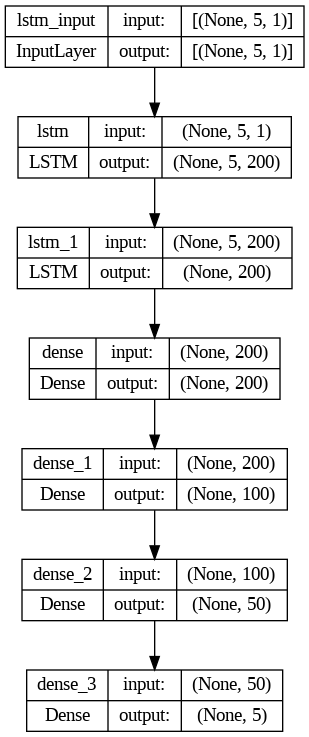

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548005 (2.09 MB)
Trainable params: 548005 

### Tasa de aprendizaje personalizada

In [9]:
def scheduler(epoch):

  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150)
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)

  return lrate

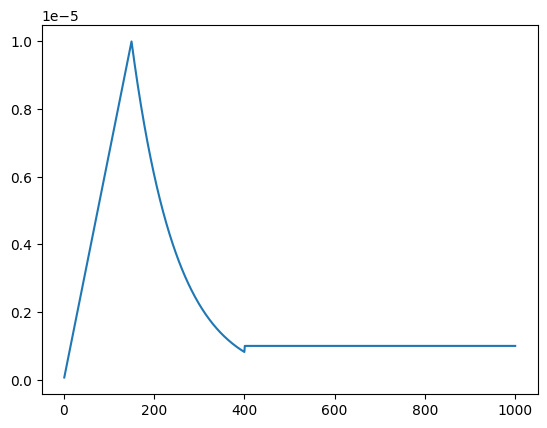

In [10]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [11]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple: Base de datos de acciones

In [12]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [13]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [14]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [15]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [16]:
AAPL_Model = Model()

In [17]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [18]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 5s 186ms/step - loss: 2297.4548 - root_mean_squared_error: 47.9318 - val_loss: 15562.8105 - val_root_mean_squared_error: 124.7510 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 48ms/step - loss: 2297.4326 - root_mean_squared_error: 47.9315 - val_loss: 15562.5264 - val_root_mean_squared_error: 124.7499 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 0s 48ms/step - loss: 2297.3604 - root_mean_squared_error: 47.9308 - val_loss: 15561.9248 - val_root_mean_squared_error: 124.7474 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 0s 49ms/step - loss: 2297.2322 - root_mean_squared_error: 47.9295 - val_loss: 15561.0234 - val_root_mean_squared_error: 124.7438 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 0s 49ms/step - loss: 2297.0559 - root_mean_squared_error: 47.9276 - val_loss: 15559.8203 - val_root_mean_squared_error: 124.7390 - lr: 2.6667e-07
Epoch 6/1

In [19]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

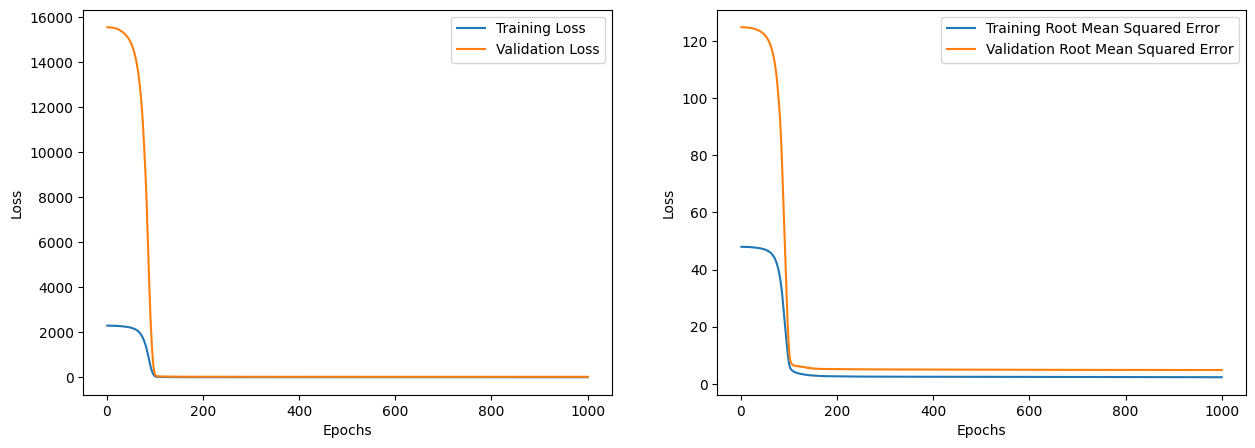

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [21]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

1/1 [==============================] - 0s 387ms/step


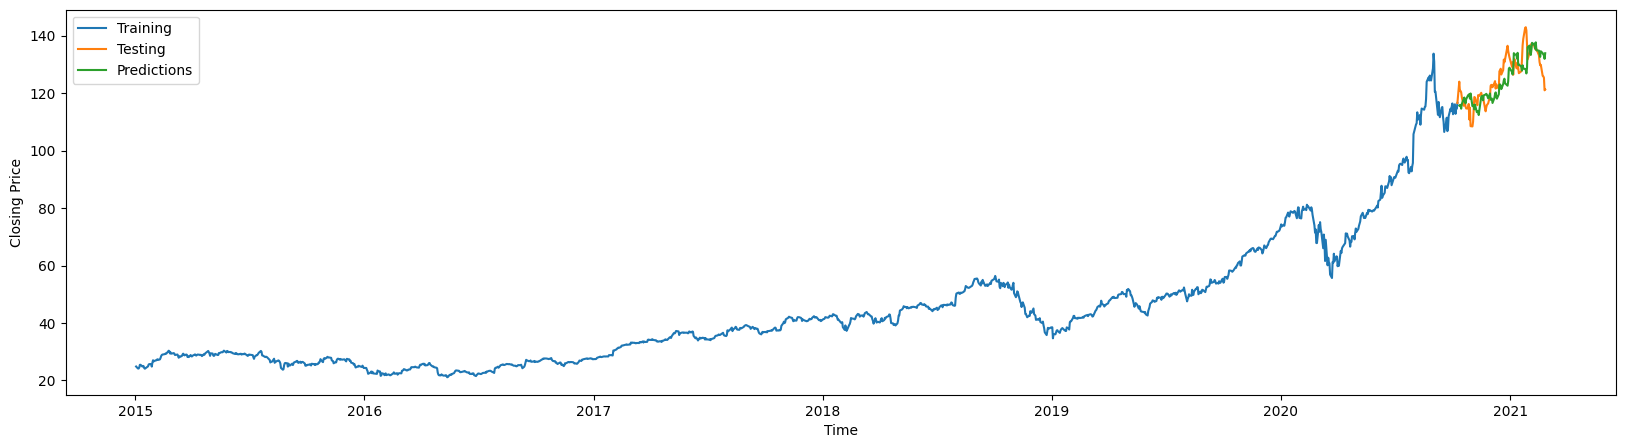

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Adj. Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Adj. Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [23]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.836094159149816
MAPE: 0.029640371021390756


#Tesla: Base de datos de acciones

In [24]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [25]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [26]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-09-30

    Periodo para partición de testing: 2020-10-01 - 2021-02-26

In [27]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Entrenamiento del modelo

In [28]:
TSLA_Model = Model()

In [29]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [30]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 3s 79ms/step - loss: 9937.8838 - root_mean_squared_error: 99.6889 - val_loss: 424325.0000 - val_root_mean_squared_error: 651.4023 - lr: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 29ms/step - loss: 9937.7949 - root_mean_squared_error: 99.6885 - val_loss: 424314.7188 - val_root_mean_squared_error: 651.3945 - lr: 6.6667e-08
Epoch 3/200
9/9 [==============================] - 0s 29ms/step - loss: 9937.5889 - root_mean_squared_error: 99.6875 - val_loss: 424291.4062 - val_root_mean_squared_error: 651.3765 - lr: 1.3333e-07
Epoch 4/200
9/9 [==============================] - 0s 31ms/step - loss: 9937.1396 - root_mean_squared_error: 99.6852 - val_loss: 424261.2500 - val_root_mean_squared_error: 651.3534 - lr: 2.0000e-07
Epoch 5/200
9/9 [==============================] - 0s 30ms/step - loss: 9936.5430 - root_mean_squared_error: 99.6822 - val_loss: 424218.9062 - val_root_mean_squared_error: 651.3209 - lr: 2.6667e-07
Epoch 6/20

In [31]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

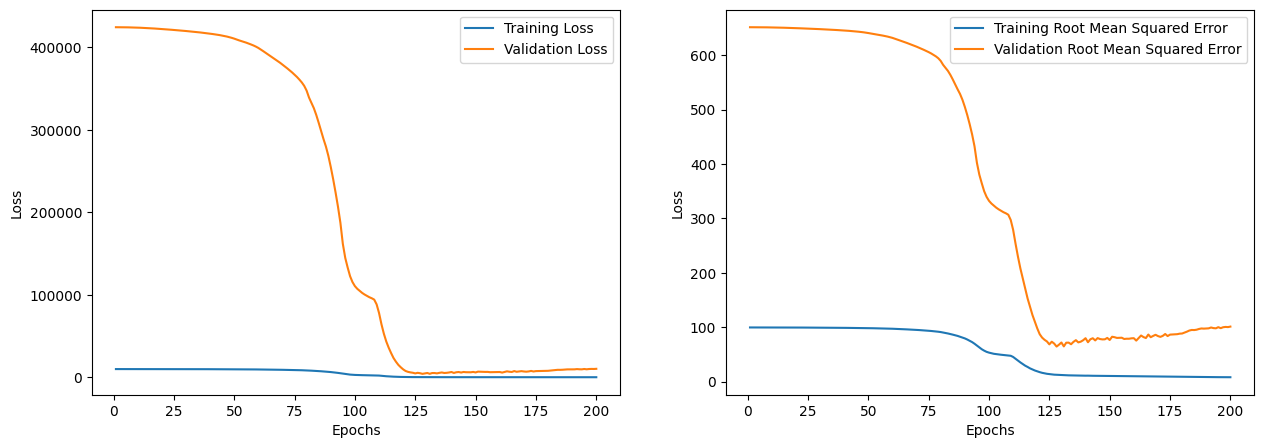

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Tesla

In [33]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

1/1 [==============================] - 0s 307ms/step


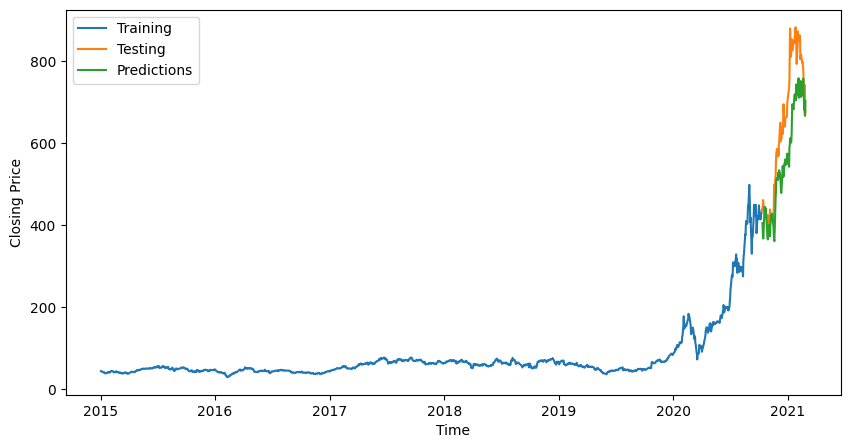

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2020-10-12'], TSLA['Adj. Close'][TSLA['Date'] < '2020-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-09'], TSLA['Adj. Close'][TSLA['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-12'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [35]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 101.24454236875964
MAPE: 0.12219356040023427


#Google: Base de datos de acciones

In [36]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [37]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [38]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-10-30

    Periodo para partición de testing: 2020-11-02 - 2021-02-26

In [39]:
GOOG_Date = '2020-11-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Entrenamiento del modelo

In [40]:
GOOG_Model = Model()

In [41]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [42]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 1000, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback])

Epoch 1/1000
10/10 [==============================] - 4s 78ms/step - loss: 1050258.6250 - root_mean_squared_error: 1024.8213 - val_loss: 3444609.2500 - val_root_mean_squared_error: 1855.9659 - lr: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 0s 45ms/step - loss: 1050251.5000 - root_mean_squared_error: 1024.8177 - val_loss: 3444532.7500 - val_root_mean_squared_error: 1855.9452 - lr: 6.6667e-08
Epoch 3/1000
10/10 [==============================] - 0s 46ms/step - loss: 1050226.1250 - root_mean_squared_error: 1024.8054 - val_loss: 3444376.0000 - val_root_mean_squared_error: 1855.9030 - lr: 1.3333e-07
Epoch 4/1000
10/10 [==============================] - 0s 45ms/step - loss: 1050182.2500 - root_mean_squared_error: 1024.7841 - val_loss: 3444158.5000 - val_root_mean_squared_error: 1855.8442 - lr: 2.0000e-07
Epoch 5/1000
10/10 [==============================] - 0s 43ms/step - loss: 1050118.5000 - root_mean_squared_error: 1024.7529 - val_loss: 3443840.7500 - val_root_mean_sq

In [43]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

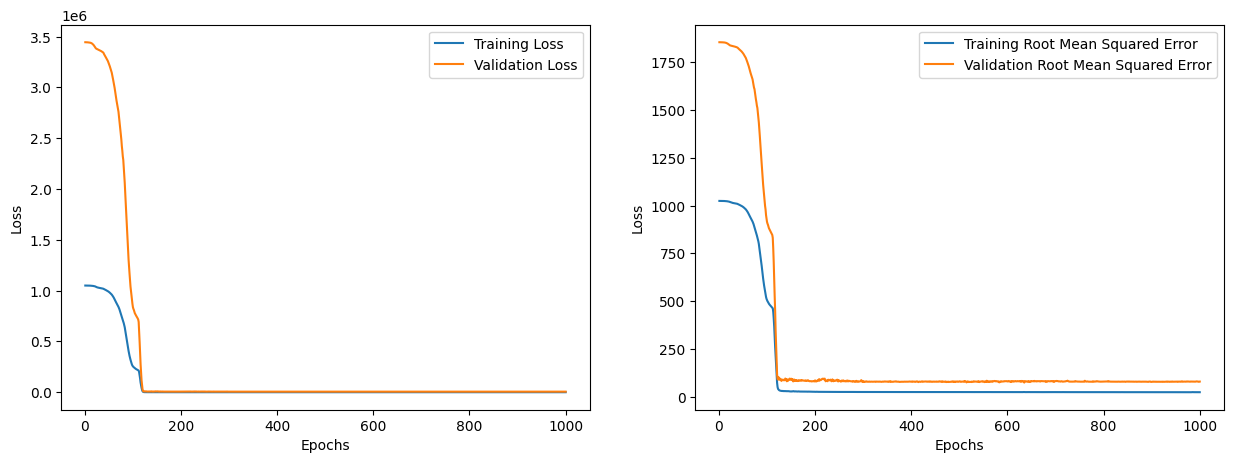

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Google

In [45]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

1/1 [==============================] - 0s 319ms/step


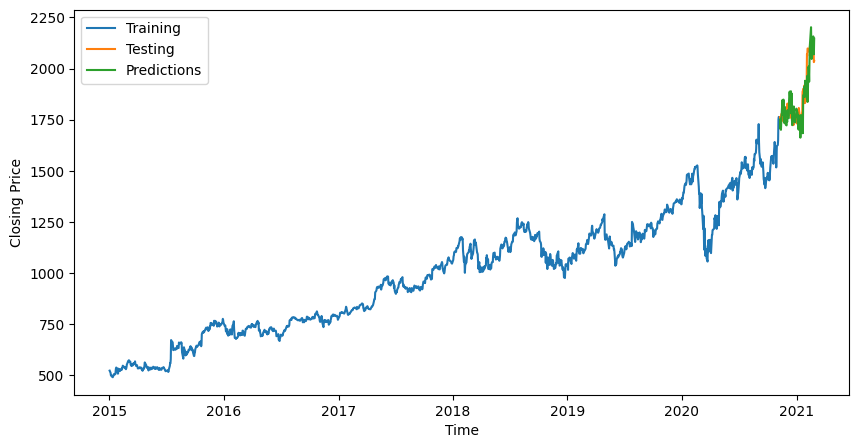

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] < '2020-11-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [47]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 78.61118347090994
MAPE: 0.03219005413677575


#Microsoft: Base de datos de acciones

In [48]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [49]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [50]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-09-30

    Periodo para partición de testing: 2020-10-01 - 2021-02-26

In [51]:
MSFT_Date = '2020-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Entrenamiento del modelo

In [52]:
MSFT_Model = Model()

In [53]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [54]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 1000, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 4s 118ms/step - loss: 10688.0361 - root_mean_squared_error: 103.3830 - val_loss: 49257.2305 - val_root_mean_squared_error: 221.9397 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 43ms/step - loss: 10687.9639 - root_mean_squared_error: 103.3826 - val_loss: 49256.2148 - val_root_mean_squared_error: 221.9374 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 0s 46ms/step - loss: 10687.7734 - root_mean_squared_error: 103.3817 - val_loss: 49254.1289 - val_root_mean_squared_error: 221.9327 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 0s 47ms/step - loss: 10687.4141 - root_mean_squared_error: 103.3799 - val_loss: 49251.0977 - val_root_mean_squared_error: 221.9259 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 0s 46ms/step - loss: 10686.9160 - root_mean_squared_error: 103.3775 - val_loss: 49247.1367 - val_root_mean_squared_error: 221.9170 - lr: 2.6667e-07

In [55]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

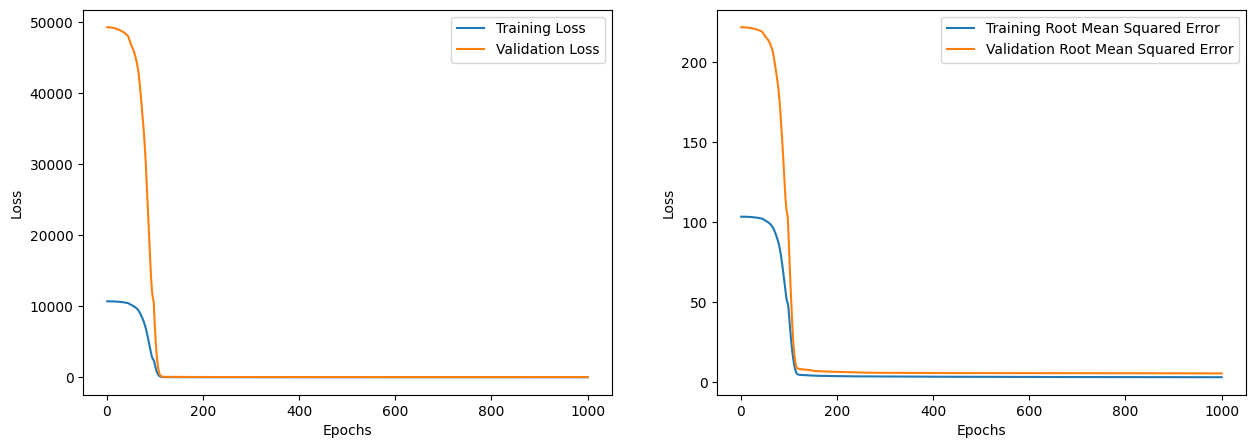

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Microsoft

In [57]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

1/1 [==============================] - 0s 320ms/step


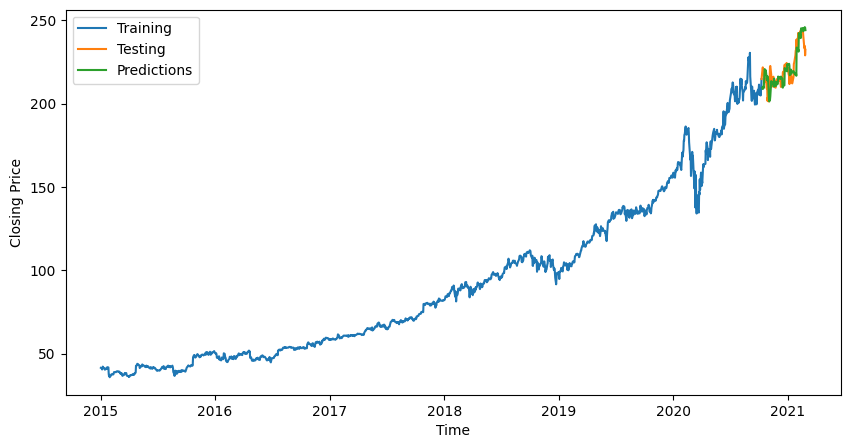

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2020-10-12'], MSFT['Adj. Close'][MSFT['Date'] < '2020-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-09'], MSFT['Adj. Close'][MSFT['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-12'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [59]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.337640055754022
MAPE: 0.01814433729553884


#Amazon: Base de datos de acciones

In [60]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [61]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [62]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-10-30

    Periodo para partición de testing: 2020-11-02 - 2021-02-26

In [63]:
AMZN_Date = '2020-11-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Entrenamiento del modelo

In [64]:
AMZN_Model = Model()

In [65]:
AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [66]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 200, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 5s 106ms/step - loss: 2296537.7500 - root_mean_squared_error: 1515.4332 - val_loss: 10260290.0000 - val_root_mean_squared_error: 3203.1689 - lr: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 0s 43ms/step - loss: 2296500.7500 - root_mean_squared_error: 1515.4210 - val_loss: 10259632.0000 - val_root_mean_squared_error: 3203.0659 - lr: 6.6667e-08
Epoch 3/200
10/10 [==============================] - 0s 45ms/step - loss: 2296372.5000 - root_mean_squared_error: 1515.3787 - val_loss: 10258340.0000 - val_root_mean_squared_error: 3202.8645 - lr: 1.3333e-07
Epoch 4/200
10/10 [==============================] - 0s 44ms/step - loss: 2296161.7500 - root_mean_squared_error: 1515.3090 - val_loss: 10256368.0000 - val_root_mean_squared_error: 3202.5564 - lr: 2.0000e-07
Epoch 5/200
10/10 [==============================] - 0s 32ms/step - loss: 2295871.5000 - root_mean_squared_error: 1515.2134 - val_loss: 10253372.0000 - val_root_mean_s

In [67]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

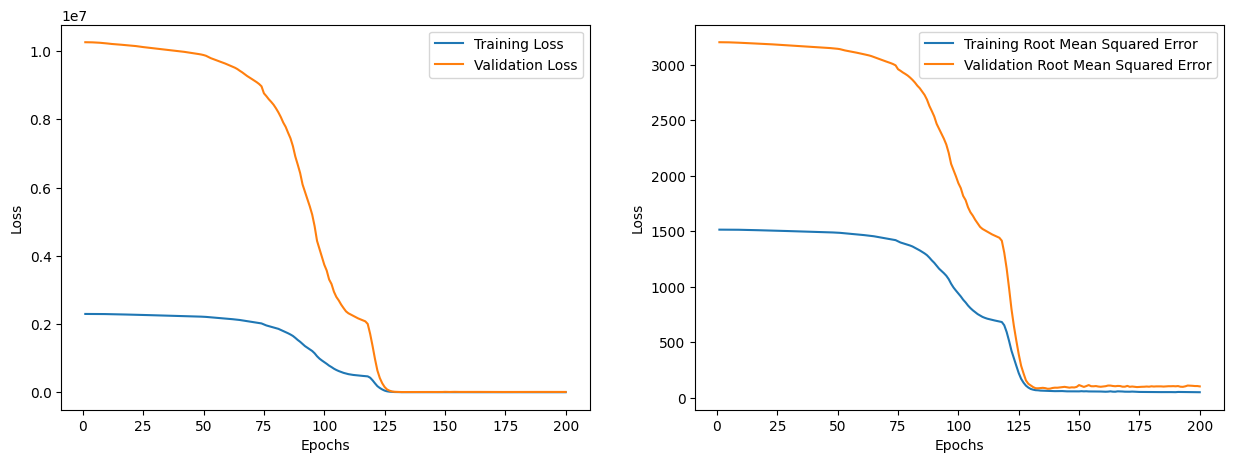

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Amazon

In [69]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

1/1 [==============================] - 0s 308ms/step


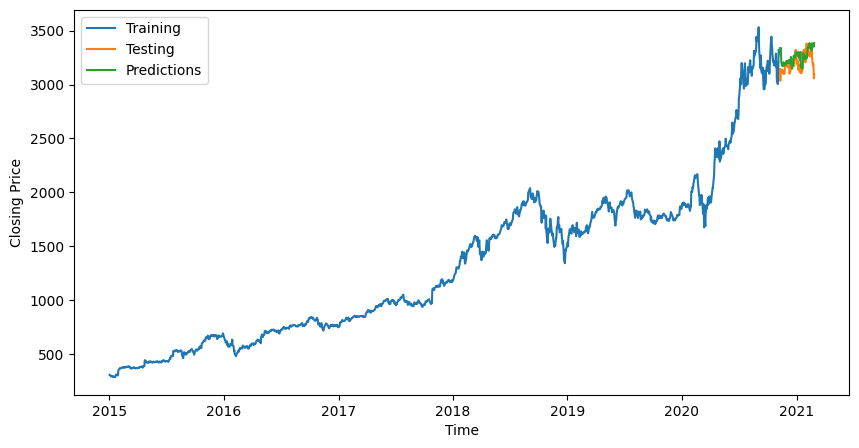

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] < '2020-11-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [71]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 103.89751108063825
MAPE: 0.025317397594177723


# Codigos extras para analisis del informe

# 1. Análisis de Métricas de Rendimiento (RMSE y MAPE)

In [72]:
def evaluate_performance(test_y, predicted_y, company_name):
    rmse = math.sqrt(mean_squared_error(test_y.reshape(-1, 5), predicted_y))
    mape = np.mean(np.abs(predicted_y - test_y.reshape(-1, 5)) / np.abs(test_y.reshape(-1, 5))) * 100
    print(f'{company_name} - RMSE: {rmse}, MAPE: {mape}%')

# Ejecuta esta función para cada compañía
evaluate_performance(AAPL_Test_Y, AAPL_prediction, "Apple")
evaluate_performance(TSLA_Test_Y, TSLA_prediction, "Tesla")
evaluate_performance(GOOG_Test_Y, GOOG_prediction, "Google")
evaluate_performance(MSFT_Test_Y, MSFT_prediction, "Microsoft")
evaluate_performance(AMZN_Test_Y, AMZN_prediction, "Amazon")


Apple - RMSE: 4.836094159149816, MAPE: 2.9640371021390757%
Tesla - RMSE: 101.24454236875964, MAPE: 12.219356040023428%
Google - RMSE: 78.61118347090994, MAPE: 3.2190054136775754%
Microsoft - RMSE: 5.337640055754022, MAPE: 1.814433729553884%
Amazon - RMSE: 103.89751108063825, MAPE: 2.531739759417772%


# 2. Resumen del Entrenamiento del Modelo

In [73]:
def summarize_training(history, company_name):
    final_epoch = len(history.history['loss'])
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_rmse = history.history['root_mean_squared_error'][-1]
    final_val_rmse = history.history['val_root_mean_squared_error'][-1]

    print(f'{company_name} - Final Epoch: {final_epoch}')
    print(f'{company_name} - Final Training Loss: {final_loss}')
    print(f'{company_name} - Final Validation Loss: {final_val_loss}')
    print(f'{company_name} - Final Training RMSE: {final_rmse}')
    print(f'{company_name} - Final Validation RMSE: {final_val_rmse}')

# Ejecuta esta función para cada compañía
summarize_training(AAPL_hist, "Apple")
summarize_training(TSLA_hist, "Tesla")
summarize_training(GOOG_hist, "Google")
summarize_training(MSFT_hist, "Microsoft")
summarize_training(AMZN_hist, "Amazon")


Apple - Final Epoch: 1000
Apple - Final Training Loss: 5.386779308319092
Apple - Final Validation Loss: 23.3878116607666
Apple - Final Training RMSE: 2.320943832397461
Apple - Final Validation RMSE: 4.836094856262207
Tesla - Final Epoch: 200
Tesla - Final Training Loss: 67.66522979736328
Tesla - Final Validation Loss: 10250.45703125
Tesla - Final Training RMSE: 8.2258882522583
Tesla - Final Validation RMSE: 101.24453735351562
Google - Final Epoch: 1000
Google - Final Training Loss: 528.505126953125
Google - Final Validation Loss: 6179.7177734375
Google - Final Training RMSE: 22.989238739013672
Google - Final Validation RMSE: 78.6111831665039
Microsoft - Final Epoch: 1000
Microsoft - Final Training Loss: 8.62004566192627
Microsoft - Final Validation Loss: 28.49040412902832
Microsoft - Final Training RMSE: 2.9359915256500244
Microsoft - Final Validation RMSE: 5.337640285491943
Amazon - Final Epoch: 200
Amazon - Final Training Loss: 2643.44677734375
Amazon - Final Validation Loss: 10794.6

# 3. Análisis de Tendencias de Pérdida y RMSE a lo Largo del Entrenamiento

In [75]:
def summarize_trends(history, company_name):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_rmse = history.history['root_mean_squared_error']
    validation_rmse = history.history['val_root_mean_squared_error']

    print(f'{company_name} - Training Loss: Start {training_loss[0]}, End {training_loss[-1]}, Max {max(training_loss)}, Min {min(training_loss)}, Mean {np.mean(training_loss)}')
    print(f'{company_name} - Validation Loss: Start {validation_loss[0]}, End {validation_loss[-1]}, Max {max(validation_loss)}, Min {min(validation_loss)}, Mean {np.mean(validation_loss)}')
    print(f'{company_name} - Training RMSE: Start {training_rmse[0]}, End {training_rmse[-1]}, Max {max(training_rmse)}, Min {min(training_rmse)}, Mean {np.mean(training_rmse)}')
    print(f'{company_name} - Validation RMSE: Start {validation_rmse[0]}, End {validation_rmse[-1]}, Max {max(validation_rmse)}, Min {min(validation_rmse)}, Mean {np.mean(validation_rmse)}')

# Ejecuta esta función para cada compañía
summarize_trends(AAPL_hist, "Apple")
summarize_trends(TSLA_hist, "Tesla")
summarize_trends(GOOG_hist, "Google")
summarize_trends(MSFT_hist, "Microsoft")
summarize_trends(AMZN_hist, "Amazon")



Apple - Training Loss: Start 2297.454833984375, End 5.386779308319092, Max 2297.454833984375, Min 5.386779308319092, Mean 190.72533881664276
Apple - Validation Loss: Start 15562.810546875, End 23.3878116607666, Max 15562.810546875, Min 23.205354690551758, Mean 1251.7725198993683
Apple - Training RMSE: Start 47.93177795410156, End 2.320943832397461, Max 47.93177795410156, Min 2.320943832397461, Mean 6.433057172775269
Apple - Validation RMSE: Start 124.75099182128906, End 4.836094856262207, Max 124.75099182128906, Min 4.817193984985352, Mean 15.198472059249879
Tesla - Training Loss: Start 9937.8837890625, End 67.66522979736328, Max 9937.8837890625, Min 67.66522979736328, Mean 4633.103405570984
Tesla - Validation Loss: Start 424325.0, End 10250.45703125, Max 424325.0, Min 4172.93603515625, Mean 195330.6474658203
Tesla - Training RMSE: Start 99.68893432617188, End 8.2258882522583, Max 99.68893432617188, Min 8.2258882522583, Mean 54.74160229682922
Tesla - Validation RMSE: Start 651.40234375